# Contexto del proyecto
prueba uso de commits
Los conjuntos de datos que utilice provienen de la web Properati, que es un sitio de búsqueda de propiedades de América Latina. En su sitio web se pueden encontrar enlaces a diferentes herramientas y conjuntos de datos pero estos no estan disponibles actualmente. Por lo tanto hice una búsqueda en kaggle de datos de properati de años anteriores y conseguí los que se encuentran en el siguiente link:

https://www.kaggle.com/datasets/tomasaccini/propiedadesproperati

Trabajaré con todos los datasets que se encuentran en el link, es decir los datos recolectados desde el año 2013 hasta el año 2017 inclusive.

El dataset de Properati proporciona valiosa información sobre el mercado inmobiliario, lo que permite comprender mejor las tendencias, los precios y los factores que influyen en la compra o venta de propiedades.

En el siguiente análisis buscamos filtrar los datos de properati para quedarnos con los mas importantes y realistas para poder predecir si el precio de una nueva propiedad es bajo, medio o alto en base a sus caracteristicas.

## Lectura y agrupamiento de los datos

Para consolidar la información de varios archivos que abarcan un período de 5 años de publicaciones, es necesario unificarlos en un único dataframe, asegurándonos de evitar la duplicación de datos.

Primero importamos las librerias necesarias para poder realizar la exploración de datos.


In [3]:
%matplotlib notebook
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math

import missingno as msno

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

plt.style.use('default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (8, 11)


#### Cargamos los datasets

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
df1 = pd.read_csv("/content/drive/MyDrive/Datasetsprop/properati-AR-2013-08-01-properties-sell.csv", low_memory=False)
df2 = pd.read_csv("/content/drive/MyDrive/Datasetsprop/properati-AR-2014-02-01-properties-sell.csv", low_memory=False)
df3 = pd.read_csv("/content/drive/MyDrive/Datasetsprop/properati-AR-2014-09-01-properties-sell.csv", low_memory=False)
df4 = pd.read_csv("/content/drive/MyDrive/Datasetsprop/properati-AR-2015-01-01-properties-sell.csv", low_memory=False)
df5 = pd.read_csv("/content/drive/MyDrive/Datasetsprop/properati-AR-2015-07-01-properties-sell-six_months.csv", low_memory=False)
df6 = pd.read_csv("/content/drive/MyDrive/Datasetsprop/properati-AR-2015-12-01-properties-sell-six_months.csv", low_memory=False)
df7 = pd.read_csv("/content/drive/MyDrive/Datasetsprop/properati-AR-2016-06-01-properties-sell.csv", low_memory=False)
df8 = pd.read_csv("/content/drive/MyDrive/Datasetsprop/properati-AR-2017-01-01-properties-sell.csv", low_memory=False)
df9 = pd.read_csv("/content/drive/MyDrive/Datasetsprop/properati-AR-2017-08-01-properties-sell-six_months.csv", low_memory=False)


Ahora ya tenemos 9 dataframes (llamados dfx, con x ={1,2,3,4,5,6,7,8,9}) que entre todos contienen todas las publicaciones de venta en 5 años. A continuación uniremos los que tengan las mismas variables.



In [16]:
df1a4 = pd.concat([df1,df2,df3,df4])
df5a9 = pd.concat([df5,df6,df7,df8,df9])
df1a4.info()
df5a9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255079 entries, 0 to 67180
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   created_on                  255079 non-null  object 
 1   operation                   255079 non-null  object 
 2   property_type               255079 non-null  object 
 3   place_name                  255079 non-null  object 
 4   place_with_parent_names     255079 non-null  object 
 5   geonames_id                 217108 non-null  float64
 6   lat-lon                     205097 non-null  object 
 7   lat                         205097 non-null  float64
 8   lon                         205094 non-null  float64
 9   price                       200715 non-null  float64
 10  currency                    200715 non-null  object 
 11  price_aprox_local_currency  200715 non-null  float64
 12  price_aprox_usd             200715 non-null  float64
 13  surface_in_m2  

In [17]:
unique_cols_df1a4=set(df1a4.columns)-set(df5a9.columns)
unique_cols_df5a9=set(df5a9.columns)-set(df1a4.columns)
common_cols=set(df5a9.columns)-unique_cols_df5a9
print('lista de caracteristicas de caracteristicas comunes', common_cols)
print('lista de caracteristicas de df1a4 que no estan en df5a9', unique_cols_df1a4)
print('lista de caracteristicas de df5a9 que no estan en df1a4', unique_cols_df5a9)


lista de caracteristicas de caracteristicas comunes {'place_name', 'place_with_parent_names', 'floor', 'price_aprox_local_currency', 'price_usd_per_m2', 'operation', 'geonames_id', 'expenses', 'currency', 'lat', 'created_on', 'rooms', 'image_thumbnail', 'property_type', 'price', 'lon', 'properati_url', 'price_aprox_usd', 'lat-lon'}
lista de caracteristicas de df1a4 que no estan en df5a9 {'surface_in_m2'}
lista de caracteristicas de df5a9 que no estan en df1a4 {'surface_covered_in_m2', 'title', 'country_name', 'description', 'price_per_m2', 'id', 'surface_total_in_m2', 'state_name'}



Como se puede observar, los dataframes 1 a 4 tienen una estructura diferente a los dataframes 5 a 9. Esto puede deberse a un cambio en el proceso de guardado de la información por parte de Properati. Ahora lo siguiente a hacer es unificarlos en un único dataframe que los contenga a todos.

Sacaremos información redundante o que no aporta al análisis, como datos internos que guarda Properati por diversas razones que no conocemos.
* '**id**': No nos aporta información.
* '**operation**': Todas las operaciones son de venta.
* '**geonames_id**': Es un id interno de Properati.
* '**lat-lon**': Es un campo que concatena los datos de los campos 'lat' y 'lon', por lo que es redundante.
* '**properati_url**': No nos aporta información.
* '**image_thumbnail**': No nos aporta información.



Verificamos que solo son ventas

In [18]:
print(df1a4.operation.unique(),df5a9.operation.unique())

['sell'] ['sell']


In [19]:
df1a4 = df1a4.drop(df1a4[['operation','created_on','geonames_id', 'lat-lon','place_name', 'properati_url','image_thumbnail']], axis = 1)
df5a9 = df5a9.drop(df5a9[['id','operation', 'created_on','geonames_id','place_name','state_name', 'lat-lon', 'properati_url','image_thumbnail','country_name', 'title']], axis = 1)

### Analisis de los atributos "surface_total_in_m2" y "surface_covered_in_m2.


Invertimos los datos de las propiedades en las cuales la superficie cubierta (surface_covered_in_m2) es mayor que la superficie total (surface_total_in_m2), ya que esto no tendría sentido y es probable que haya sido un error al ingresar los datos.






In [20]:
sup_mask = df5a9['surface_covered_in_m2'] > df5a9['surface_total_in_m2']
print(f'Cantidad de filas con sup_cov > sup_total: {sup_mask.sum()}')

def invertir_sup_cov(row):
    if row['surface_covered_in_m2'] > row['surface_total_in_m2']:
        return row['surface_total_in_m2'], row['surface_covered_in_m2']
    else:
        return row['surface_covered_in_m2'], row['surface_total_in_m2']

df5a9['surface_covered_in_m2'], df5a9['surface_total_in_m2'] = zip(*df5a9.apply(invertir_sup_cov, axis=1)) #invierte los datos


Cantidad de filas con sup_cov > sup_total: 11521


Recuperamos datos desde las descripciones en el dataframe df5a9 para la variable surface_total_in_m2.

In [21]:
# Obtengo la superficie en m2 desde la descripción.
cant_surf_old=df5a9['surface_total_in_m2'].count() #guardamos en una variable para comparar cuantos datos ganamos.

tmp = df5a9.loc[(df5a9['surface_total_in_m2'].isnull()), 'description'].str.lower().str.extract("(\d+)(\s|())(mt|m2|metros|metros2)", expand=False)
'''
Selecciona las filas en las que el valor de la columna 'surface_total_in_m2' es
NaN y extrae la información de la columna 'description' en minúsculas. Luego,
utiliza una expresión regular para buscar un número seguido de la palabra
"mt","m2",etc. La función extract() captura el número encontrado y el espacio en blanco que lo
precede, si corresponde, y lo guarda en la variable 'tmp'.
'''
# Asigno la cantidad de ambientes, al dataset original donde rooms es NaN
df5a9.loc[df5a9['surface_total_in_m2'].isnull(),'surface_total_in_m2'] = tmp[0]

df5a9['surface_total_in_m2'] = df5a9['surface_total_in_m2'].astype(float)

# Contamos la cantidad de datos recuperados
cant_surf_new=df5a9['surface_total_in_m2'].count()
print('Se puede observar que pudimos rescatar de la caracteristica surface_total_in_m2', cant_surf_new-cant_surf_old, 'ejemplos')


Se puede observar que pudimos rescatar de la caracteristica surface_total_in_m2 30772 ejemplos


Para evitar eliminar columnas importantes tenemos que unificar 'surface_total_in_m2' con 'surface_covered_in_m2' que se encuentran en df5a9 y llamar a esa unión 'surface_in_m2'. Limpiemos el dataframe de los registros con datos de superficie invalidos (menores a 10, mayores a 10.000, por ser valores lejanos a la realidad), ya que es un dato clave y sin este dato no podemos determinar el valor de una propiedad.

In [22]:
invalidos = ((df5a9['surface_covered_in_m2'] < 10) | (df5a9['surface_covered_in_m2'] > 10000)) & ((df5a9['surface_total_in_m2'] < 10) | (df5a9['surface_total_in_m2'] > 10000))
df5a9 = df5a9[~invalidos]
ambos_iguales = df5a9['surface_covered_in_m2'] == df5a9['surface_total_in_m2']
ambos_iguales.value_counts()

False    238872
True      58014
dtype: int64

Hay 58014 registros que son iguales, los cuales podemos unificar sin problema. Si uno de los valores es nulo, nos quedaremos con la superficie del otro valor no nulo. En caso que ambos valores sean diferentes, nos quedaremos con la superficie total.
El resultado lo guardaremos en una nueva columna llamada **surface_in_m2**, para llamarla igual que en el df1a4.

In [23]:
def obtener_superficie_final(row):
    covered = row['surface_covered_in_m2']
    total = row['surface_total_in_m2']
    if pd.isnull(covered):
        return total
    elif pd.isnull(total):
        return covered
    elif covered == total:
        return total
    else:
        return total

df5a9['surface_in_m2'] = df5a9.apply(obtener_superficie_final, axis=1)
df5a9 = df5a9.drop(['surface_covered_in_m2', 'surface_total_in_m2'], axis=1)


### Analisis de los atributos "price_usd_per_m2" y "price_per_m2"
Para que queden las mismas columnas, en df5a9 tenemos que unificar 'price_usd_per_m2' con 'price_per_m2'.

Ahora tenemos que unificar 'price_usd_per_m2' con 'price_per_m2' que se encuentran en df5a9 y llamar a esa unión 'price_usd_per_m2'. Limpiemos el dataframe de los registros con datos de precios invalidos (menores a 100, mayores a 10.000, por ser valores lejanos a la realidad).




In [24]:
invalidos = ((df5a9['price_usd_per_m2'] < 100) | (df5a9['price_usd_per_m2'] > 10000)) & ((df5a9['price_per_m2'] < 100) | (df5a9['price_per_m2'] > 10000))
df5a9 = df5a9[~invalidos]
ambos_iguales = df5a9['price_usd_per_m2'] == df5a9['price_per_m2']
ambos_iguales.value_counts()

False    256143
True      39635
dtype: int64



Hay 39635 registros que son iguales, los cuales podemos unificar sin problema. Si uno de los valores es nulo, nos quedaremos con el precio del otro valor no nulo.En caso de que ambos valores sean diferentes, nos quedaremos con el price_per_m2.
El resultado lo guardaremos en una nueva columna llamada '**price_usd_per_m2**', para mantener coherencia con el df1a4.

In [25]:
def obtener_precio_por_m2_final(price_usd_per_m2, price_per_m2):
    if pd.isnull(price_usd_per_m2):
        return price_per_m2
    elif pd.isnull(price_per_m2):
        return price_usd_per_m2
    elif price_usd_per_m2 == price_per_m2:
        return price_per_m2
    else:
        return price_per_m2

df5a9.loc[:, 'price_usd_per_m2'] = df5a9[['price_usd_per_m2', 'price_per_m2']].apply(lambda x: obtener_precio_por_m2_final(x[0], x[1]), axis=1)
df5a9 = df5a9.drop('price_per_m2', axis=1)


Además, podemos ver si se pueden recuperar datos nulos en la variable "price" desde la variable "description".

In [26]:
cant_price_old=df5a9['price'].count() #guardamos en una variable para comparar cuantos datos ganamos.

tmp = df5a9.loc[(df5a9['price'].isnull()), 'description'].str.lower().str.extract("(\d+)(\s|())($USD|$US|precio|usd)", expand=False)
'''
Selecciona las filas en las que el valor de la columna 'price_per_m2' es NaN y extrae
la información de la columna 'description'. Luego, utiliza una
expresión regular para buscar un número seguido de la palabra "precio", "$", etc.
La función extract() captura el número encontrado y el espacio en blanco que lo precede, si corresponde,
y lo guarda en la variable 'tmp'.
'''
# Asigno la cantidad de ambientes, al dataset original donde rooms es NaN
df5a9.loc[df5a9['price'].isnull(),'price'] = tmp[0]

# Asignamos 1 a las propiedades que en su descripción tengan la palabra 'monoambiente'
#inmuebles.loc[(inmuebles['rooms'].isnull()) & (inmuebles['description'].str.lower().str.contains('monoambiente')),'rooms'] = 1

df5a9['price'] = df5a9['price'].astype(float)

# Contamos la cantidad de datos recuperados
cant_price_new=df5a9['price'].count()
print('Se puede observar que pudimos rescatar de la caracteristica price', cant_price_new-cant_price_old, 'ejemplos')



Se puede observar que pudimos rescatar de la caracteristica price 182 ejemplos


### Analisis del atributo "rooms"
Ahora nos fijaremos si podemos recuperar datos nulos de la variable "rooms" desde la variable "description"

In [27]:
cant_ambientes_old=df5a9['rooms'].count() #guardamos en una variable para comparar cuantos datos ganamos.

tmp1 = df5a9.loc[(df5a9['rooms'].isnull()),'description'].str.lower().str.extract("(\d+)(\s|())amb", expand=False)
'''
Selecciona las filas en las que el valor de la columna 'rooms' es NaN y extrae
la información de la columna 'description' en minúsculas. Luego, utiliza una
expresión regular para buscar un número seguido de la palabra "amb"
(por ejemplo, "2 ambientes", "3amb", etc.). La función extract() captura el
número encontrado y el espacio en blanco que lo precede, si corresponde,
y lo guarda en la variable 'tmp'.
'''
# Asigno la cantidad de ambientes, al dataset original donde rooms es NaN
df5a9.loc[df5a9['rooms'].isnull(),'rooms'] = tmp1[0]

# Asignamos 1 a las propiedades que en su descripción tengan la palabra 'monoambiente'
df5a9.loc[(df5a9['rooms'].isnull()) & (df5a9['description'].str.lower().str.contains('monoambiente')),'rooms'] = 1

df5a9['rooms'] = df5a9['rooms'].astype(float)

# Contamos la cantidad de datos recuperados
cant_ambientes_new=df5a9['rooms'].count()
print('se puede observar que pudimos rescatar de la caracteristica rooms', cant_ambientes_new-cant_ambientes_old, 'registros')



se puede observar que pudimos rescatar de la caracteristica rooms 42505 registros


### Atributo place_names

Dividiremos del atributo place_with_parent_names los datos Pais,Provincia,Ciudad y Barrio.

In [28]:
def split_place(df):
  # Extraer las columnas de país, provincia, ciudad y barrio si hay cuatro elementos
  df[['pais', 'provincia', 'ciudad', 'barrio']] = df['place_with_parent_names'].str.extract(r'\|([^|]+)\|([^|]+)?\|([^|]+)?\|?([^|]+)?|$', expand=True)
  # Reemplazar valores vacíos por NaN
  df.replace('', np.nan, inplace=True)
  return df

In [29]:
df1a4=split_place(df1a4)
df5a9=split_place(df5a9)

In [30]:
#estas funciones reemplazan todos los nombres de buenos aires a solo buenos aires

def crear_diccionario(lista, valor_fijo):
    diccionario = {}
    for elemento in lista:
        diccionario[elemento] = valor_fijo
    return diccionario

def reemplazo_bsas(df):
  filtro = df.provincia.str.startswith(('Bs.As.', 'Buenos'))
  bs_filtrados = df.loc[filtro, 'provincia'].unique()
  bs_filtrados = crear_diccionario(bs_filtrados,'Buenos aires')
  df['provincia'] = df['provincia'].replace(bs_filtrados)
  return df


In [31]:
df1a4=reemplazo_bsas(df1a4)
df5a9=reemplazo_bsas(df5a9)


# union de los dataset

Verifiquemos que ambas estructuras tienen las mismas columnas, y concatenemos todas las publicaciones en un unico dataframe llamado properties.



In [32]:
columns1a4 = df1a4.columns.tolist().sort()
columns5a9 = df5a9.columns.tolist().sort()
columns1a4 == columns5a9

True

Finalmente podemos unir nuestros conjuntos y obtenemos uno nuevo con las siguientes caracteristicas:


In [33]:
inmuebles = pd.concat([df1a4,df5a9])
type(inmuebles)
inmuebles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550857 entries, 0 to 121219
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   property_type               550857 non-null  object 
 1   place_with_parent_names     550857 non-null  object 
 2   lat                         405235 non-null  float64
 3   lon                         405232 non-null  float64
 4   price                       462148 non-null  float64
 5   currency                    450892 non-null  object 
 6   price_aprox_local_currency  461966 non-null  float64
 7   price_aprox_usd             461966 non-null  float64
 8   surface_in_m2               432394 non-null  float64
 9   price_usd_per_m2            356538 non-null  float64
 10  floor                       72954 non-null   float64
 11  rooms                       368691 non-null  float64
 12  expenses                    36777 non-null   object 
 13  pais          

**Empezamos con un dataset de 550857 datos**

### Diccionario de las características



* '**property_type**' : Tipo de propiedad de las cuales puede ser 'house', 'apartment', 'PH', 'store'.
* '**place_with_parent_names**': Dato concatenado que provee, Pais,Provincia,Ciudad, Barrio. el formato es x|x|x|x o x|x|x. donde Ciudad o Barrio varia.
* '**lat**': Latitud geografia.
* '**lon**': Longitud geografica.
* '**price**': Precio
* '**currency**': Moneda en la cual se encuentra el precio
* '**price_aprox_local_currency**':precio aproximado en la moneda local
* '**price_aprox_usd**': Precio aproximado en dolares
* **'surface_in_m2'**: Superficie en metros cuadrados.
* '**price_usd_per_m2**': Precio en USD por metro cuadrado
* '**floor**': Cantidad de pisos.
* '**rooms**': Habitaciones.
* '**expenses**': Expensas.
* '**pais**':  Pais fue sacado de "place_with_parent_names"
* '**provincia**': Las provincias fueron sacados de "place_with_parent_names"
* '**ciudad**':  Las ciudades fueron sacadas de "place_with_parent_names"
* '**barrio**': Los barrio fueron sacados de "place_with_parent_names"
* '**description**': Descripción dada por las personas que publican los anuncios.



Veamos graficamente donde se encuentran los datos nulos de cada caracteristica.

/usr/local/lib/python3.10/dist-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


<Axes: >

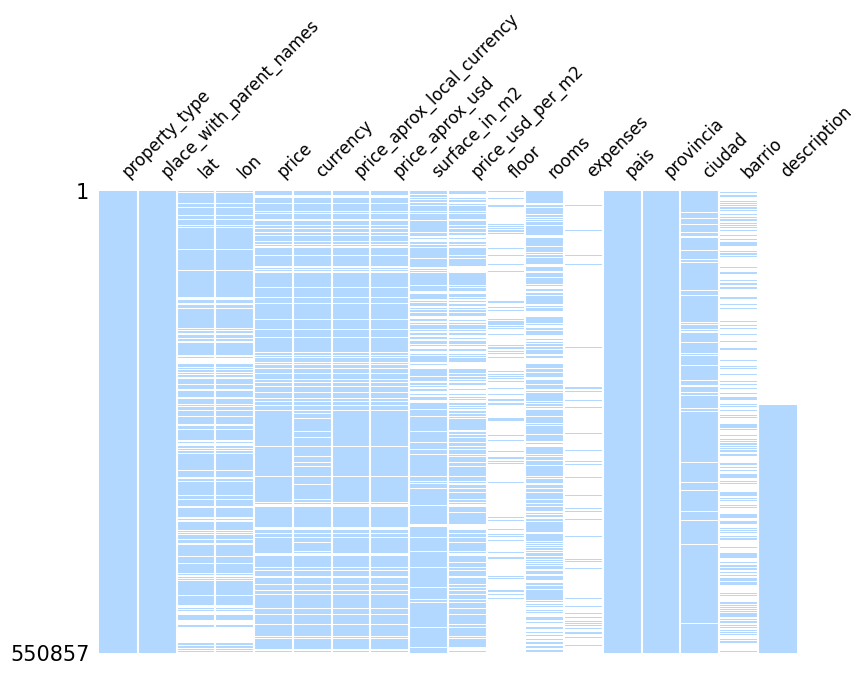

In [34]:
fig, ax = plt.subplots(figsize=(9, 6))
msno.matrix(inmuebles, ax=ax, fontsize=12, color=(0.7, 0.85, 1))

Usamos solo las clases que son de nuestro interes


In [35]:
inmuebles = inmuebles.loc[inmuebles['currency'] == 'USD']
clases1 = inmuebles['currency'].unique()
print(clases1)

inmuebles = inmuebles.loc[inmuebles['property_type'] != 'store']
clases2 =inmuebles['property_type'].unique()
print(clases2)

inmuebles = inmuebles.loc[inmuebles['pais'] == 'Argentina']
clases2 =inmuebles['pais'].unique()
print(clases2)


['USD']
['house' 'apartment' 'PH']
['Argentina']


Creamos una función que ordene de mayor a menor las caracteristicas con datos nulos.

In [36]:
def inspect_dataframe(df):
    "Muestra los datos de un dataframe como en '.info()' pero ordena de mayor a menor los valores nulos."
    # Cantidad total de registros
    total_rows = len(df)
    # Creamos el dataframe donde vamos a mostrar la estructura del dataset
    # Algo así como el .info() pero con mas información.
    df_retval = pd.DataFrame(columns=['NaNs #','NaNs %','Type'])
    # Por cada columna
    for col in df.columns:
        # Cantidad de Valores nulos
        nan_values = df[col].isnull().sum()
        # Porcentaje de Valores Nulos en el dataset
        nan_percentage = nan_values / total_rows * 100
        # El tipo de dato de la columna
        datatype = df[col].dtype
        # Agrego la fila al dataframe
        df_retval.loc[col] = [nan_values, nan_percentage, datatype]
    # Ordeno los valores por % de NaNs
    return df_retval.sort_values(by='NaNs %', ascending=False)

In [37]:
inspect_dataframe(inmuebles)

NaNs #     NaNs %     Type
expenses                    349545  91.566969   object
floor                       327557  85.806982  float64
barrio                      236211  61.877942   object
description                 165587  43.377247   object
rooms                       111469  29.200470  float64
lon                         101305  26.537904  float64
lat                         101302  26.537118  float64
price_usd_per_m2             76150  19.948289  float64
surface_in_m2                69027  18.082345  float64
ciudad                       23643   6.193531   object
place_with_parent_names          0   0.000000   object
price_aprox_usd                  0   0.000000  float64
price_aprox_local_currency       0   0.000000  float64
currency                         0   0.000000   object
pais                             0   0.000000   object
provincia                        0   0.000000   object
price                            0   0.000000  float64
property_type                    0   0.000000   object

Creamos una copia del dataset para no modificar el original

In [38]:
inm=inmuebles.copy()  #creamos una copia para no romper nada

A continuación quitamos variables que no necesitaremos

In [39]:
inm = inm.drop(['place_with_parent_names', #utliziamos este campo para extraer informacion
                'currency', #esta entrada es igual para todos los registros
                'floor', #lamentablemente la base de datos carece de este dato en el %85.80 de los registros
                'expenses', #lamentablemente la base de datos carece de este dato en el %91.56 de los registros
                'pais',#esta entrada es igual para todos los registros
                'ciudad', #la extraemo por que no podemos validar bien la informacion de esta categoria combia a veces barrios con ciudades
                'barrio', #lamentablemente la base de datos carece de este dato en el %61.87 de los registros
                'description' #utiliziamos este campo para extraer informacion pero ya no nos sirve
                ], axis=1)


/usr/local/lib/python3.10/dist-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


<Axes: >

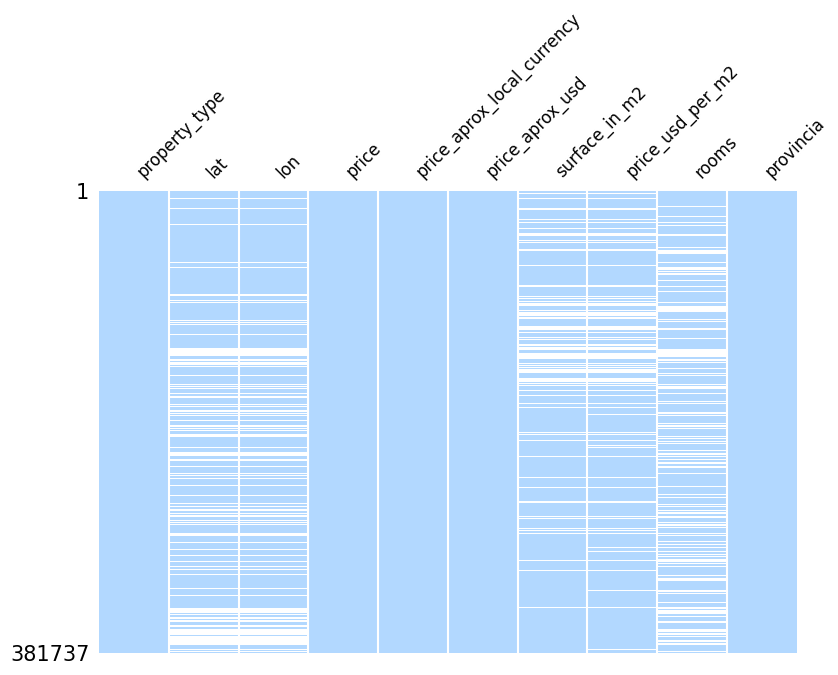

In [40]:
fig, ax = plt.subplots(figsize=(9, 6))
msno.matrix(inm, ax=ax, fontsize=12, color=(0.7, 0.85, 1))

Este grafico me muestra la ubicación que ocupan los datos nulos en mi dataset.

Notemos que la variable "price_usd_per_m2" se puede obtener mediante la ecuacion
$$
price\_usd\_per\_m2 = \frac{price}{surface\_in\_m2}.
$$
Por lo tanto podemos recuperar datos nulos de la siguiente manera,

In [41]:
cant_price_usd_per_m2_old = inm['price_usd_per_m2'].count()  # guardamos en una variable para comparar cuántos datos ganamos.

mask = inm['price_usd_per_m2'].isnull()
inm.loc[mask, 'price_usd_per_m2'] = inm.loc[mask, 'price'] / inm.loc[mask, 'surface_in_m2']
# Contamos la cantidad de datos recuperados
cant_price_usd_per_m2_new = inm['price_usd_per_m2'].count()
print('Se puede observar que pudimos rescatar de la característica "price_usd_per_m2"', cant_price_usd_per_m2_new - cant_price_usd_per_m2_old, 'ejemplos.')


Se puede observar que pudimos rescatar de la característica "price_usd_per_m2" 7082 ejemplos.


<Axes: >

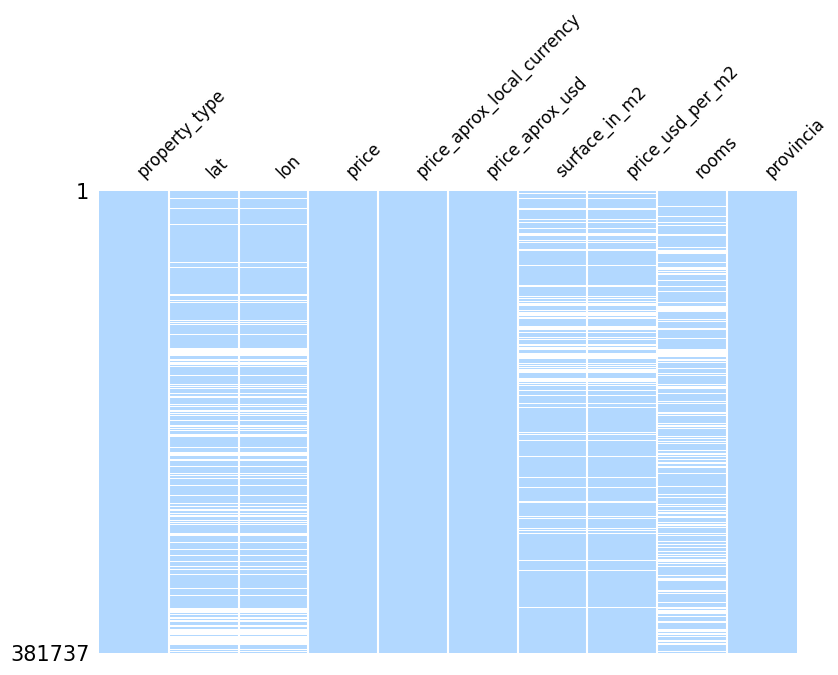

In [42]:
fig, ax = plt.subplots(figsize=(9, 6))
msno.matrix(inm, ax=ax, fontsize=12, color=(0.7, 0.85, 1))

Procedemos a eliminar todos los datos nulos

In [43]:
inm = inm.dropna()


Limpidemos los registros con datos irreales. Esta limpieza es necesaria debido a que los datos de Properati son ingresados por las personas que publican los anuncios, y muchos de ellas llenan incorrectamente los formularios o dejan campos vacíos (como los datos nulos que hemos eliminado en la línea anterior)

In [44]:
#Limpieza de price_usd_per_m2
indices = inm.index[(inm['price_usd_per_m2'] >= 10000) | (inm['price_usd_per_m2'] < 100)]
inm.drop(indices, inplace=True)


#Limpieza de surface_in_m2
indices1 = inm.index[(inm['surface_in_m2'] > 1000) | (inm['surface_in_m2'] < 10)]
#print(indices)
inm.drop(indices1, inplace=True)


#Limpieza de Rooms
inm['rooms'] = inm['rooms'].replace(0, 1)
indices2 = inm.index[(inm['rooms'] >= 15) | (inm['rooms'] < 1)]
inm.drop(indices2, inplace=True)
condition = ((inm['rooms'] <= 1) & (inm['surface_in_m2'] >= 250)) | \
            ((inm['rooms'] <= 2) & (inm['surface_in_m2'] >= 350)) | \
            ((inm['rooms'] <= 3) & (inm['surface_in_m2'] >= 450)) | \
            ((inm['rooms'] <= 4) & (inm['surface_in_m2'] >= 550)) | \
            ((inm['rooms'] <= 5) & (inm['surface_in_m2'] >= 650)) | \
            ((inm['rooms'] <= 6) & (inm['surface_in_m2'] >= 750))
indices3 = inm[condition].index
inm= inm.drop(indices3)
condition = ((inm['rooms'] >= 6) & (inm['surface_in_m2'] <= 60)) | \
            ((inm['rooms'] >= 7) & (inm['surface_in_m2'] <= 80)) | \
            ((inm['rooms'] >= 8) & (inm['surface_in_m2'] <= 100)) | \
            ((inm['rooms'] >= 9) & (inm['surface_in_m2'] <= 120)) | \
            ((inm['rooms'] >= 10) & (inm['surface_in_m2'] <= 140)) | \
            ((inm['rooms'] >= 11) & (inm['surface_in_m2'] <=160))
indices4 = inm[condition].index
inm= inm.drop(indices4)


#Limpieza lat y lon
indices5 = inm.index[(inm['lat'] >= -10)| (inm['lat'] < -54.7)]
inm.drop(indices5, inplace=True)
indices6 = inm.index[(inm['lon'] < -80) | (inm['lon'] > -50)]
inm.drop(indices6, inplace=True)
# Sacamos puntos en particular que estan mal
condition2 = ((np.isclose(inm["lat"], -33.18284, rtol=1e-05) & np.isclose(inm["lon"], -70.65227, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -33.53119, rtol=1e-05) & np.isclose(inm["lon"], -70.60439, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -33.61466, rtol=1e-05) & np.isclose(inm["lon"], -70.61815, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -38.58253, rtol=1e-05) & np.isclose(inm["lon"], -57.32666, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -34.92238, rtol=1e-05) & np.isclose(inm["lon"], -55.04383, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -34.85161, rtol=1e-05) & np.isclose(inm["lon"], -56.14721, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -34.90325, rtol=1e-05) & np.isclose(inm["lon"], -54.81405, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -34.947, rtol=1e-05) & np.isclose(inm["lon"], -54.92056, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -25.61187, rtol=1e-05) & np.isclose(inm["lon"], -54.54073, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -25.62122, rtol=1e-05) & np.isclose(inm["lon"], -54.59329, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -25.51834, rtol=1e-05) & np.isclose(inm["lon"], -54.54951, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -29.70993, rtol=1e-05) & np.isclose(inm["lon"], -59.08768, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -34, rtol=1e-05) & np.isclose(inm["lon"], -58, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -34.93167, rtol=1e-05) & np.isclose(inm["lon"], -54.92056, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -34.90566, rtol=1e-05) & np.isclose(inm["lon"], -55.04024, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -34.90616, rtol=1e-05) & np.isclose(inm["lon"], -55.04268, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -34.90997, rtol=1e-05) & np.isclose(inm["lon"], -55.04385, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -34.91197, rtol=1e-05) & np.isclose(inm["lon"], -55.0439, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -34.93167, rtol=1e-05) & np.isclose(inm["lon"], -54.95587, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -34.93167, rtol=1e-05) & np.isclose(inm["lon"], -54.92056, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -34.947, rtol=1e-05) & np.isclose(inm["lon"], -54.95587, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -34.88488, rtol=1e-05) & np.isclose(inm["lon"], -55.04515, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -42.09822, rtol=1e-05) & np.isclose(inm["lon"], -72.46582, rtol=1e-05))) | \
             ((np.isclose(inm["lat"], -34.90644, rtol=1e-05) & np.isclose(inm["lon"], -56.19804, rtol=1e-05)))
indices7 = inm[condition2].index
inm = inm.drop(indices7)


<ipython-input-44-b5331a8fffe1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inm.drop(indices, inplace=True)
<ipython-input-44-b5331a8fffe1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inm.drop(indices1, inplace=True)
<ipython-input-44-b5331a8fffe1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inm['rooms'] = inm['rooms'].replace(0, 1)


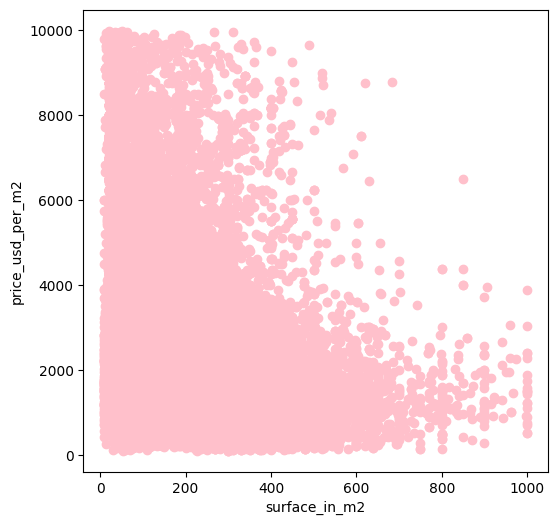

In [45]:
import matplotlib.pyplot as plt

# Datos de ejemplo
x = inm['surface_in_m2']
y = inm['price_usd_per_m2']

# Crear el gráfico de dispersión
plt.figure(figsize=(6, 6))
plt.scatter(x, y, color='pink')

# Configurar etiquetas de los ejes
plt.xlabel('surface_in_m2')
plt.ylabel('price_usd_per_m2')

# Mostrar el gráfico
plt.show()

Este grafico es bastante confuso, pero a la ves tiene sentido la variación de precios que puede tener un mismo valor de superficie ya que no es lo mismo comprar un monoambiente en palermo que comprar un monoambiente en un barrio lejano a la ciudad.

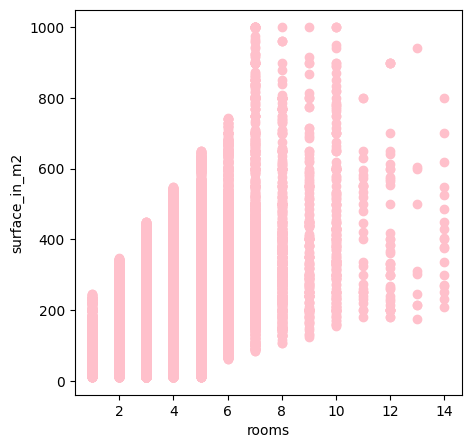

In [46]:
import matplotlib.pyplot as plt

# Datos de ejemplo
x = inm['rooms']
y = inm['surface_in_m2']

# Crear el gráfico de dispersión
plt.figure(figsize=(5, 5))
plt.scatter(x, y, color='pink')

# Configurar etiquetas de los ejes
plt.xlabel('rooms')
plt.ylabel('surface_in_m2')

# Mostrar el gráfico
plt.show()


Este gráfico mejora gracias a la limpieza de datos anómalos que hicimos anteriormente ya que sino ibamos a tener un grádico donde todo el cuadrado eran puntos azules sin niguna correlación.

A continuación, vamos a dividir nuestros precios en 3 categorías: 'bajo', 'medio' y 'alto', con el objetivo de tener aproximadamente la misma cantidad de datos en cada clase. Esto se hace para evitar un desbalance de clases y asegurar que todas las categorías tengan una representación equitativa en nuestros datos.

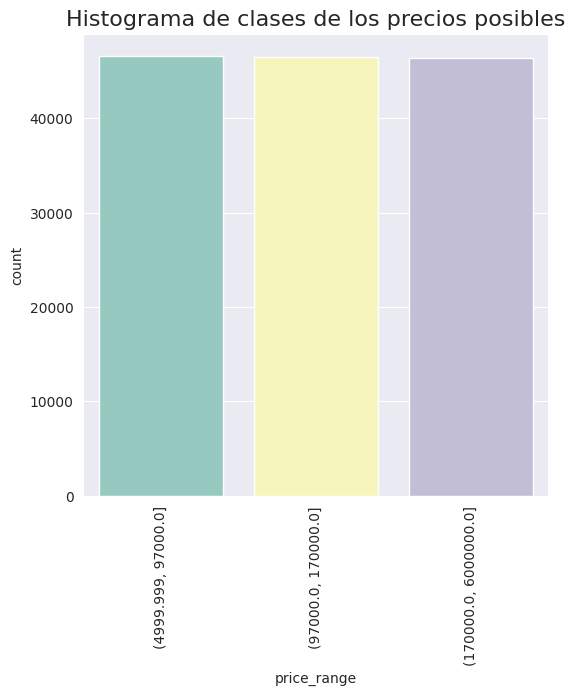

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Crear columnas de intervalos de precios con igual frecuencia
inm['price_range'] = pd.qcut(inm['price'], q=3)  # Cambia el valor de 'q' según el número de intervalos deseados

plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
ax = sns.countplot(x='price_range', data=inm, palette="Set3")
ax.set_title('Histograma de clases de los precios posibles', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()


A continuación, graficaremos simultáneamente los datos de las variables 'lat' y 'lon' en un mapa mundial para visualizar la distribución de las ubicaciones. Además, utilizaremos colores para diferenciar las diferentes clases de datos, que son: 'bajo', 'medio' y 'alto'.

In [48]:
import plotly.express as px
import re
import numpy as np
inm['price_clas'] = pd.cut(inm['price'], bins=[5000.0, 110000.0, 170000.0, 6000000.0], include_lowest=True)
fig = px.scatter_geo(inm, lat=inm.lat, lon=inm.lon, color='price_clas', scope='world')
fig.update_geos(fitbounds="locations")

# Agregar las fronteras de los países
fig.update_geos(showcountries=True, countrycolor='gray', countrywidth=1)
fig.show()


En este grafico vemos lo que debemos clasificar y se ve claramente lo superpuestos que estan los puntos.

# Analisis de correlación de las variables

Analizamos la variable surface_in_m2 y su relación con el precio por m2 para identificar si el precio está correlacionado con  la superficie.


Text(0.5, 1.0, 'Relación de Precio vs Superficie')

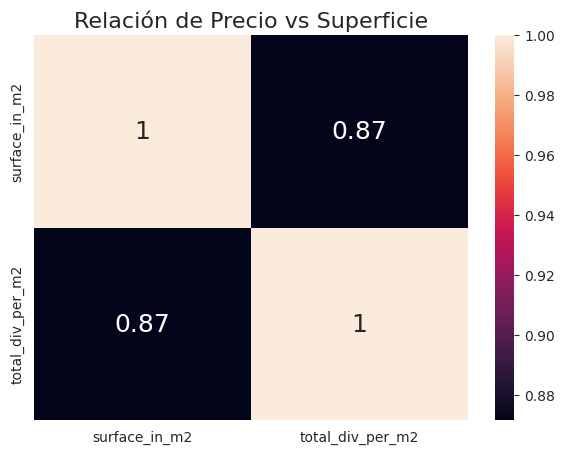

In [49]:
df_tmp = inm[['price_aprox_usd','price_usd_per_m2','surface_in_m2']].copy()
df_tmp['total_div_per_m2'] = df_tmp['price_aprox_usd'] / df_tmp['price_usd_per_m2']

plt.figure(figsize=(7,5))
sns.heatmap(df_tmp[['surface_in_m2','total_div_per_m2']].corr(), annot=True, annot_kws={"size": 18})
plt.title('Relación de Precio vs Superficie', fontsize=16)


Como era de esperarse, hay una alta correlación entre estas 2 variables.

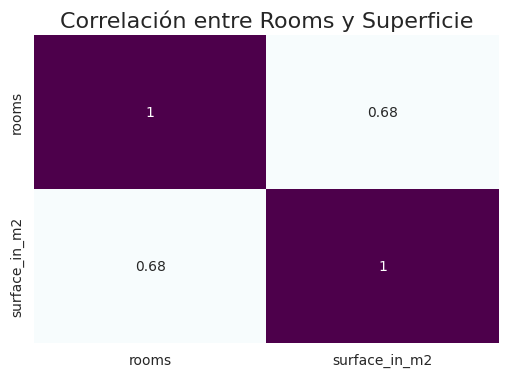

In [50]:
#Correlación entre Rooms y superficie.
correlation_matrix = inm[['rooms', 'surface_in_m2']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="BuPu", cbar=False)
plt.title('Correlación entre Rooms y Superficie', fontsize=16)
plt.show()


Para poder utilizar los clasificadores transformar las variables categoricas a enteros para poder incluirlas en nuestros clasificadores.


In [51]:
inm['property_type'] = inm['property_type'].factorize()[0]
clases_nuevas = inm['property_type'].unique()

inm['provincia'] = inm['provincia'].factorize()[0]
clases_nuevas2 = inm['provincia'].unique()


In [52]:
inm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139523 entries, 4 to 121217
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   property_type               139523 non-null  int64   
 1   lat                         139523 non-null  float64 
 2   lon                         139523 non-null  float64 
 3   price                       139523 non-null  float64 
 4   price_aprox_local_currency  139523 non-null  float64 
 5   price_aprox_usd             139523 non-null  float64 
 6   surface_in_m2               139523 non-null  float64 
 7   price_usd_per_m2            139523 non-null  float64 
 8   rooms                       139523 non-null  float64 
 9   provincia                   139523 non-null  int64   
 10  price_range                 139523 non-null  category
 11  price_clas                  139523 non-null  category
dtypes: category(2), float64(8), int64(2)
memory usage: 12.0 MB

Vamos a comenzar a clasificar con 139523 datos.

# Voy a clasificar con distintos clasificadores. Hasta ahora use, Naive bayes, árboles, Knn, SVM, Random Forest.


#Naive


In [53]:
#NAIVE BAYES
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

inm['price_range'] = pd.qcut(inm['price'], q=3)
label_encoder = LabelEncoder()
inm['price_class'] = label_encoder.fit_transform(inm['price_range']) #Esto me da las clases como 0 1 2

X = inm.drop(['price_class','price_clas','price_range','price_aprox_local_currency','price','price_aprox_usd','price_usd_per_m2'], axis=1).copy()
y = inm['price_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = GaussianNB()
model.fit(X_train, y_train)

# Obtener las clases del modelo
classes = model.classes_
nombres_clases = ['Bajo', 'Medio', 'Alto']
nuevos_nombres = {clase: nombre for clase, nombre in zip(classes, nombres_clases)}
classes = [nuevos_nombres[clase] for clase in classes]
print(classes)


['Bajo', 'Medio', 'Alto']


              precision    recall  f1-score   support

        Bajo       0.57      0.79      0.66     11738
       Medio       0.41      0.36      0.39     11750
        Alto       0.67      0.48      0.56     11393

    accuracy                           0.54     34881
   macro avg       0.55      0.54      0.53     34881
weighted avg       0.55      0.54      0.53     34881



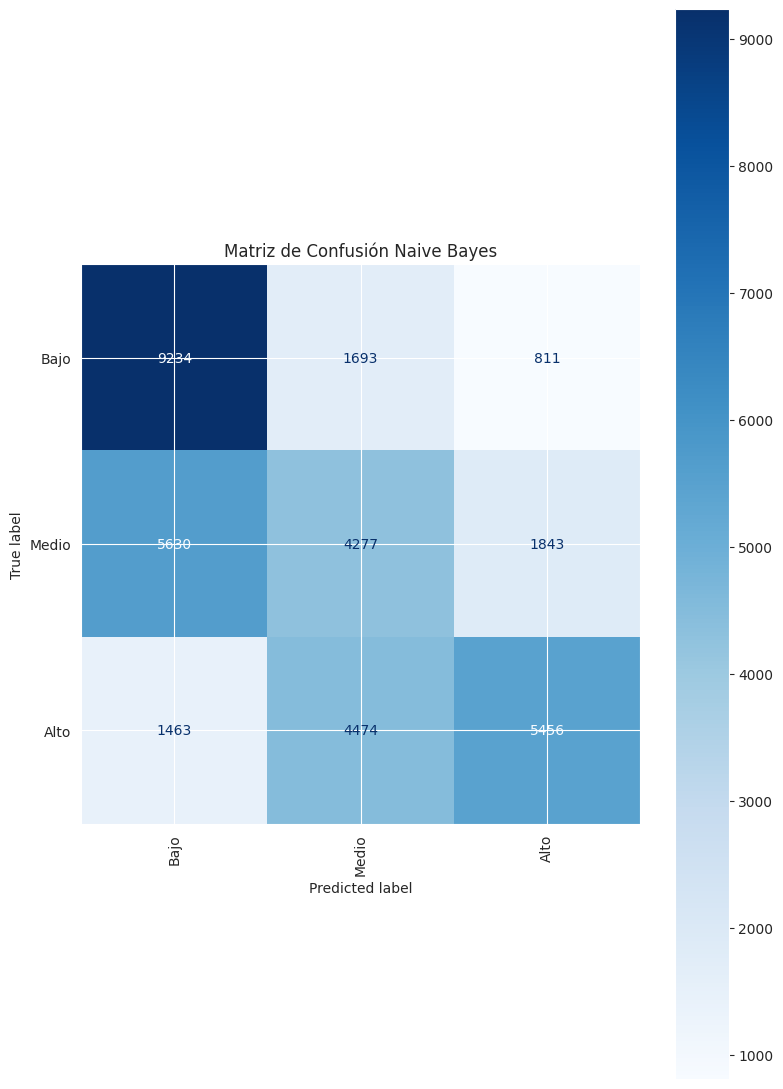

In [52]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
    )
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=classes, cmap='Blues', xticks_rotation='vertical', ax=None)
print(classification_report(y_test, y_pred, target_names=classes))
plt.title('Matriz de Confusión Naive Bayes')
plt.tight_layout()
plt.show()


Era de esperar que el clasificador de naive bayes nos diera un accuracy muy bajo, pero utilizaremos este clasificador para setear un baseline de comparación.

#K-Nearest Neighbors


In [53]:
#KNN
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

inm['price_range'] = pd.qcut(inm['price'], q=3)
label_encoder = LabelEncoder()
inm['price_class'] = label_encoder.fit_transform(inm['price_range'])

X = inm[['property_type', 'provincia', 'lat', 'lon', 'surface_in_m2', 'rooms']]
y = inm['price_class']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train,y_train)
y_pred_knn = knn_clf.predict(X_test)

Precisión del clasificador KNN: 0.76
              precision    recall  f1-score   support

           0       0.79      0.80      0.80     11738
           1       0.67      0.66      0.67     11750
           2       0.81      0.82      0.82     11393

    accuracy                           0.76     34881
   macro avg       0.76      0.76      0.76     34881
weighted avg       0.76      0.76      0.76     34881



Text(0.5, 1.0, 'Matriz de Confusión KNN')

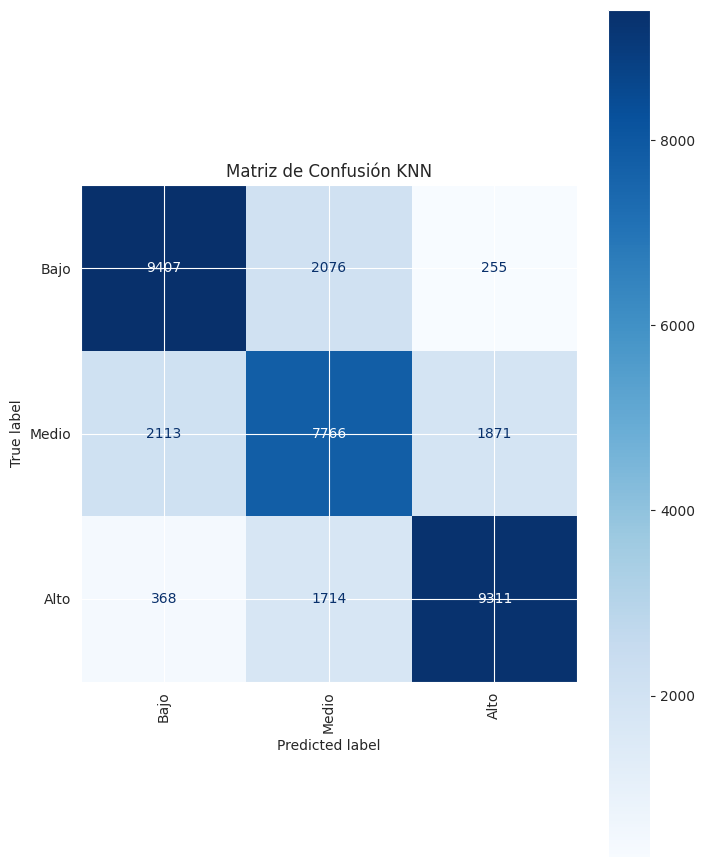

In [54]:
accuracy_knn = accuracy_score(y_test.values, y_pred_knn)

print("Precisión del clasificador KNN: {:.2f}".format(accuracy_knn))
confusion_matriz_knn = confusion_matrix(y_true=y_test, y_pred=y_pred_knn)
print(classification_report(y_test, y_pred_knn))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_knn, display_labels=classes, cmap='Blues', xticks_rotation='vertical', ax=None)

plt.title('Matriz de Confusión KNN')


Se eligió KNN ya que es un algoritmo no paramétrico, es deicr que no asume una distribución específica de los datos. Esto lo hace adecuado para datos de Properati, ya que estos pueden tener características complejas y no lineales.

El resultado obtenido por KNN nos sorprendio ya que no es muy distinto a los accuracys de los métodos que siguen en el proyecto. En un principio, teníamos la percepción de que KNN era considerado un clasificador básico para este problema, sin embargo, los resultados demostraron que KNN puede ser una buena opción para la clasificación de datos de Properati.






#Árboles de desición

accuracy del clasificador: 0.79
              precision    recall  f1-score   support

        Bajo       0.82      0.83      0.82     11738
       Medio       0.71      0.70      0.70     11750
        Alto       0.83      0.84      0.83     11393

    accuracy                           0.79     34881
   macro avg       0.79      0.79      0.79     34881
weighted avg       0.79      0.79      0.79     34881



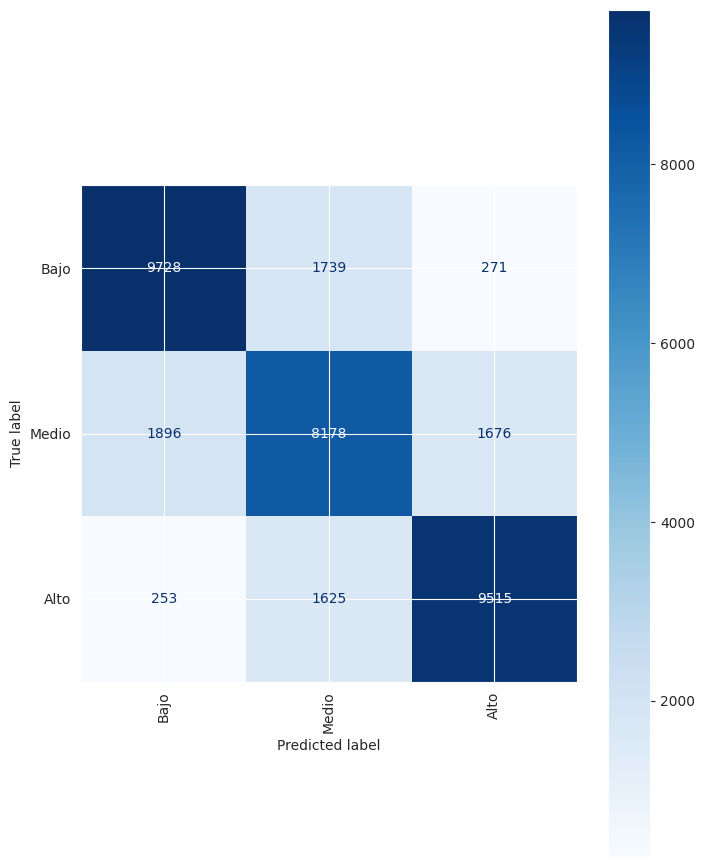

In [55]:
#Este es ajustando a ojo el parametro max_depth y entropy
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X = inm.drop(['price_class','price_clas','price_range','price_aprox_local_currency','price','price_aprox_usd','price_usd_per_m2'], axis=1).copy()
y = inm['price_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf = DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf= 1)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Evaluamos el rendimiento del modelo.
accuracy = accuracy_score(y_test.values, y_pred)
print("accuracy del clasificador: {:.2f}".format(accuracy))
reporte_clasif = classification_report(y_true=y_test.values, y_pred=y_pred,target_names=classes)
print(reporte_clasif)
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test, y_pred=y_pred, display_labels=classes, cmap='Blues', xticks_rotation='vertical', ax=None)

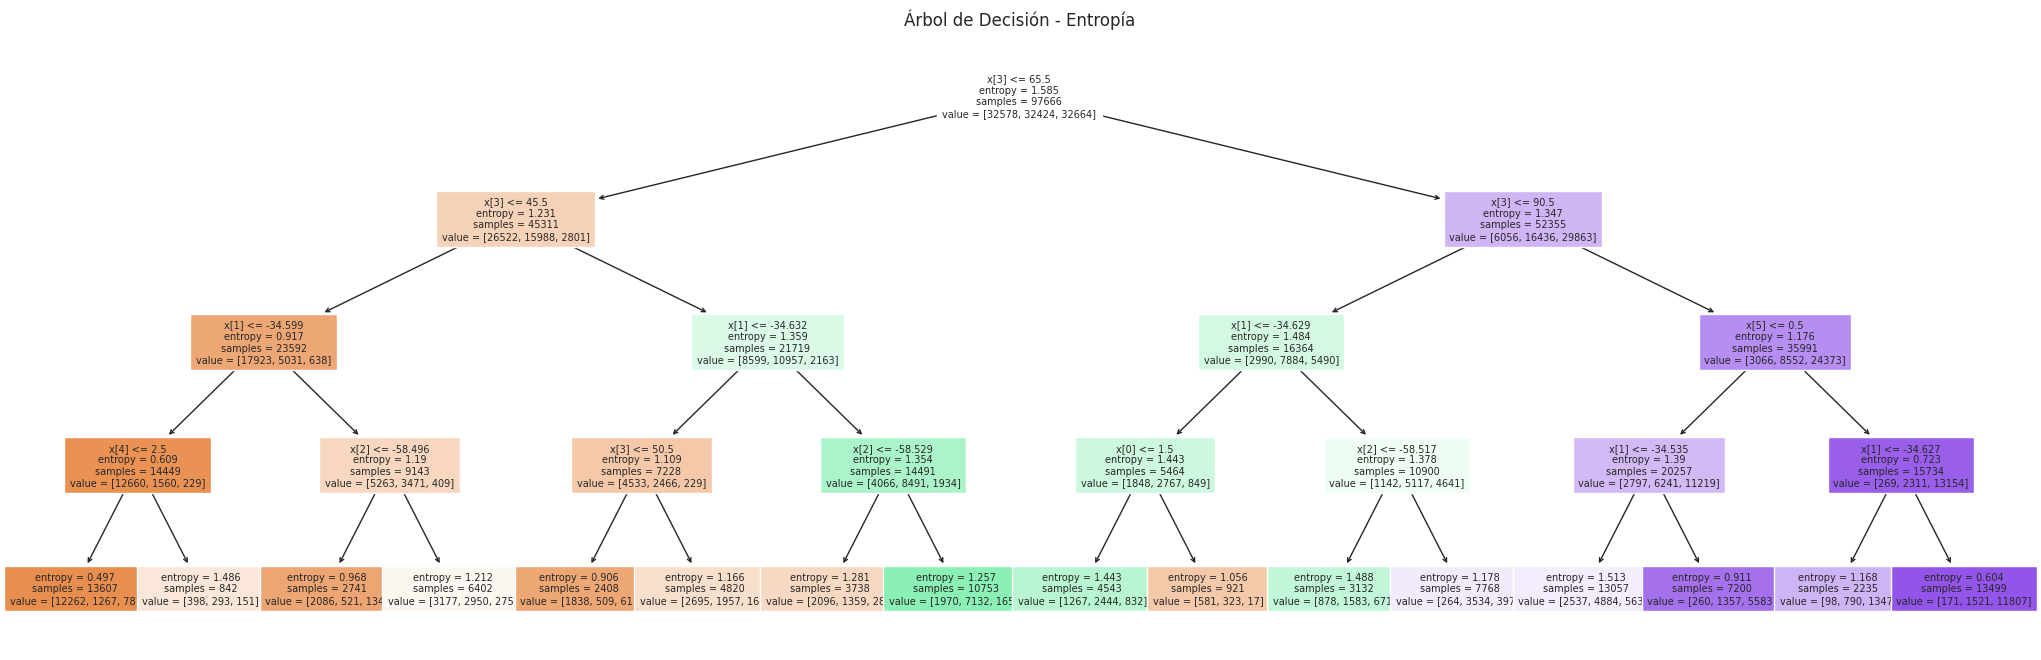

In [56]:
#Este el grafico con el criterio entropy  con 4 niveles para que se vea bien
from sklearn.tree import DecisionTreeClassifier, plot_tree

X = inm.drop(['price_class','price_clas','price_range','price_aprox_local_currency','price','price_aprox_usd','price_usd_per_m2'], axis=1).copy()
y = inm['price_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model_entropy = DecisionTreeClassifier(criterion='entropy',max_depth=4).fit(X_train,y_train)
plt.figure(figsize=(26,8))
plot_tree(model_entropy,filled=True, fontsize=7)
plt.title('Árbol de Decisión - Entropía')
plt.show()



La elección de utilizar árboles de decisión en nuestro proyecto de Properati se basa en que son algoritmos versátiles y pueden manejar conjuntos de datos grandes sin requerir un preprocesamiento exhaustivo. Esto nos permite trabajar rápidamente con el gran volumen de datos recopilados en el proyecto Properati. Sin embargo, hemos variado los párametos pero no logramos superar el accuracy de 0.79, el cual me parece bajo para el método que estamos utilizando.



#RandomForestClassifier

accuracy del clasificador: 0.83
              precision    recall  f1-score   support

        Bajo       0.86      0.86      0.86     11738
       Medio       0.77      0.76      0.76     11750
        Alto       0.87      0.87      0.87     11393

    accuracy                           0.83     34881
   macro avg       0.83      0.83      0.83     34881
weighted avg       0.83      0.83      0.83     34881



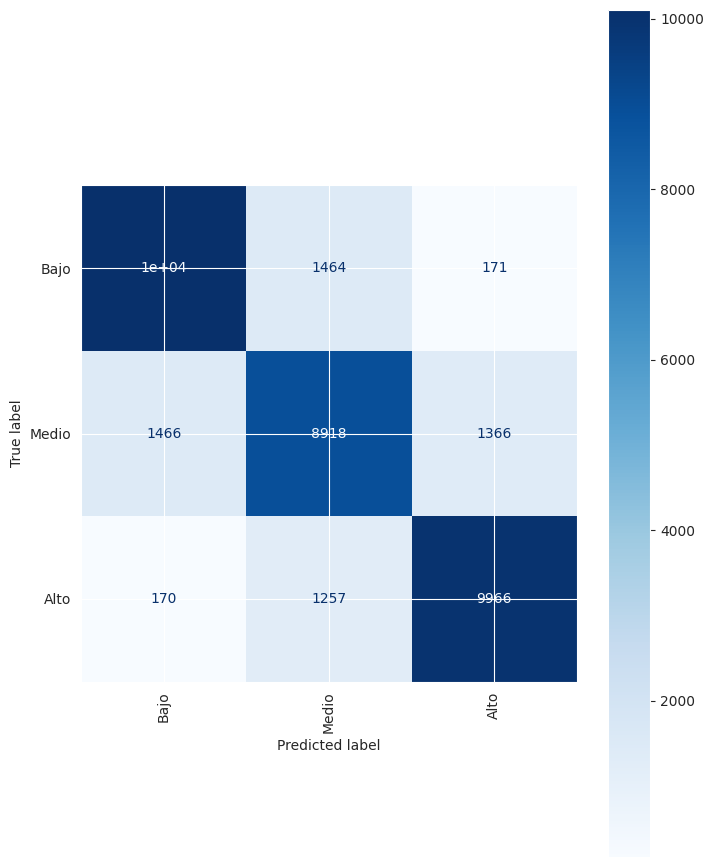

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


# Crear columna de intervalos de precios utilizando .loc para asignar valores
inm['price_range'] = pd.qcut(inm['price'], q=3)
label_encoder = LabelEncoder()
inm['price_class'] = label_encoder.fit_transform(inm['price_range'])

X = inm[['property_type', 'provincia', 'lat', 'lon', 'surface_in_m2', 'rooms']]
y = inm['price_class']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train,y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_rf = rf_clf.predict(X_test)

# Calcular precisión del modelo
accuracy_rf = accuracy_score(y_test.values, y_pred_rf)
print("accuracy del clasificador: {:.2f}".format(accuracy_rf))
reporte_clasif = classification_report(y_true=y_test.values, y_pred=y_pred_rf,target_names=classes)
print(reporte_clasif)
confusion_matriz_rf = confusion_matrix(y_true=y_test, y_pred=y_pred_rf)
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test, y_pred=y_pred_rf, display_labels=classes, cmap='Blues', xticks_rotation='vertical', ax=None)


La elección de utilizar Random Forest en nuestro proyecto se basa en sus capacidades de mejora de la precisión y manejo de características complejas. Random Forest es un algoritmo que combina múltiples árboles de decisión, lo que nos permite obtener predicciones más precisas y robustas.
En este caso, fue el algoritmo que mejor accuracy nos dio, lo cual era lo que esperabamos.

#GradientBoostingClassifier

In [58]:
from sklearn.ensemble import GradientBoostingClassifier
X = inm[['property_type', 'provincia', 'lat', 'lon', 'surface_in_m2', 'rooms']]
y = inm['price_class']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)


boost = GradientBoostingClassifier(n_estimators=20,
                                   learning_rate=0.5,
                                   max_depth=19,
                                   random_state=42)

boost.fit(X_train, y_train)

print("Test Accuracy: %0.2f" % boost.score(X_test, y_test))
# Realizar predicciones en el conjunto de prueba
y_pred = boost.predict(X_test)

# Calcular precisión del modelo
accuracy_rf = accuracy_score(y_test.values, y_pred)
print("accuracy del clasificador: {:.2f}".format(accuracy_rf))


Test Accuracy: 0.83
accuracy del clasificador: 0.83


NameError: ignored

              precision    recall  f1-score   support

        Bajo       0.86      0.86      0.86     11738
       Medio       0.76      0.76      0.76     11750
        Alto       0.87      0.87      0.87     11393

    accuracy                           0.83     34881
   macro avg       0.83      0.83      0.83     34881
weighted avg       0.83      0.83      0.83     34881



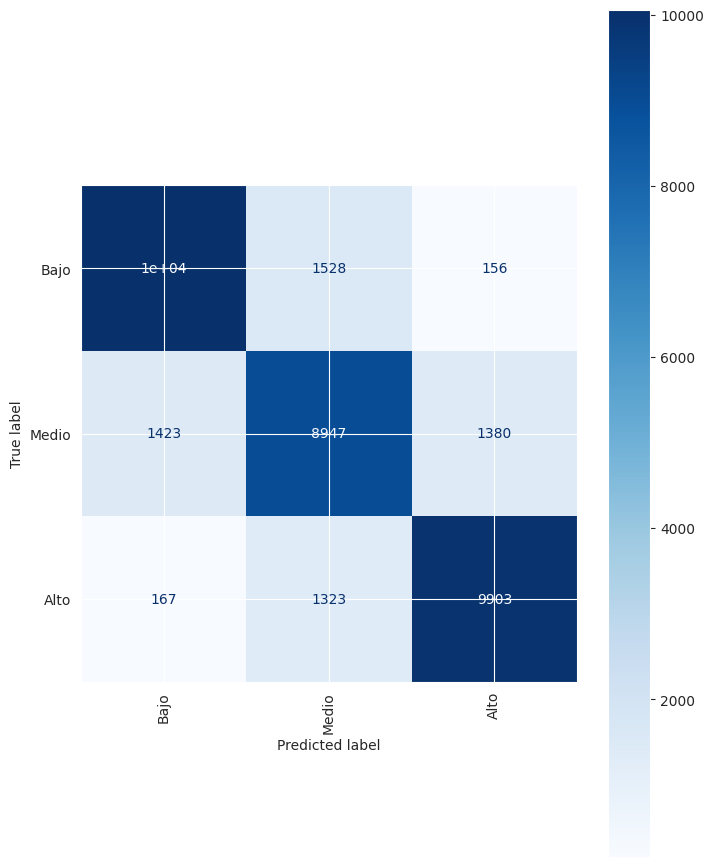

In [59]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

reporte_clasif = classification_report(y_true=y_test.values, y_pred=y_pred,target_names=classes)
print(reporte_clasif)
confusion_matriz_rf = confusion_matrix(y_true=y_test, y_pred=y_pred)
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred, display_labels=classes, cmap='Blues', xticks_rotation='vertical', ax=None)


GradientBoostingClassifier es capaz de manejar características heterogéneas, lo que es beneficioso para los conjuntos de datos de Properati que contienen una variedad de características, como ubicación, tamaño, tipo de propiedad, etc.

Algo que quedo pendiente es hacer Suppor vector Machine ya que lo habiamos implementado en versiones anteriores a esta versión final pero por los tiempos de demora no pudimos agregarlo. La idea es la siguiente:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

X = inm[['property_type', 'provincia', 'lat', 'lon', 'surface_in_m2', 'rooms']]
y = inm['price_class']

scaler = StandardScaler()
X = scaler.fit_transform(X)

C_range = np.logspace(0, 2, 10)
gamma_range = np.logspace(-1, 0, 6)

param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5,train_size=0.1, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)
print(gamma_range)
print(C_range)

Esto habia dado la siguiente salida,

The best parameters are {'C': 59.94842503189409, 'gamma': 0.15848931924611134} with a score of 0.80

[0.1        0.15848932 0.25118864 0.39810717 0.63095734 1.        ]

[  1.           1.66810054   2.7825594    4.64158883   7.74263683
  12.91549665  21.5443469   35.93813664  59.94842503 100.        ]

La cual no pudimos correr nuevamente por los tiempos de demora. Pero se puede observar que el score era 0.80. Por lo que ibamos a obtener una predicción similar a Random Forest.

#Conclusión:


A pesar de los resultados obtenidos, el mayor desafío fue la limpieza de datos. Dado que el conjunto de datos se obtuvo de campos llenados por personas, lo cual implicó encontrarmos con una gran cantidad de datos absurdos o nulos. Incluso después de realizar una exhaustiva limpieza, pasamos de tener 550.857 datos a clasificar con solo 139.523, es decir aproximadamente solo el 25.32% de los datos originales fueron utilizados.